In [105]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from func_data import *


In [106]:
df=pd.read_csv(r"D:\data\WA_Fn-UseC_-HR-Employee-Attrition.csv")
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0}) # zmieniamy wartości na Boolean
print(df.shape)
df.dropna # odrzucamy wiersze z wartościami NaN
df.shape

(1470, 35)


(1470, 35)

Old Shape:  (1470, 35)
New Shape:  (1458, 35)


C:\Users\karol\AppData\Local\Temp\ipykernel_2940\3086587621.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  remove_outliers_pos(df,column_name='MonthlyIncome')


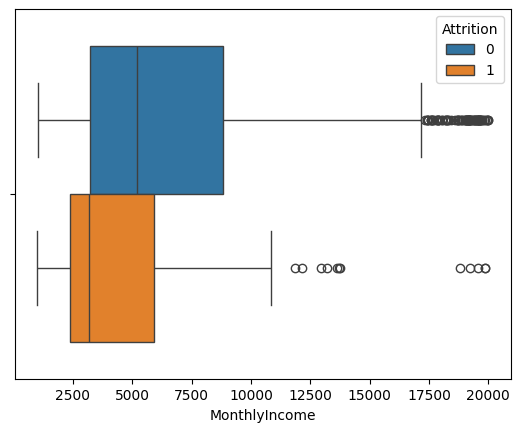

In [107]:
remove_outliers_pos(df,column_name='MonthlyIncome')


Old Shape:  (1458, 35)
New Shape:  (1377, 35)


C:\Users\karol\AppData\Local\Temp\ipykernel_2940\1513729800.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  remove_outliers_neg(df,column_name="MonthlyIncome")


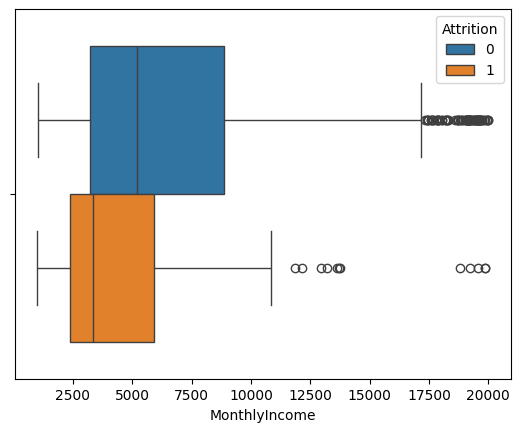

In [108]:
remove_outliers_neg(df,column_name="MonthlyIncome")

In [109]:
neg, pos = np.bincount(df['Attrition'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 1377
    Positive: 223 (16.19% of total)



In [110]:
df=one_hot_encode_dataframe(df)

In [111]:
train_df, test_df = train_test_split(df, test_size=0.15,random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15,random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Attrition'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Attrition'))
test_labels = np.array(test_df.pop('Attrition'))


train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [112]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (994,)
Validation labels shape: (176,)
Test labels shape: (207,)
Training features shape: (994, 55)
Validation features shape: (176, 55)
Test features shape: (207, 55)


In [113]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(
          32, activation='relu',
          ),
      keras.layers.Dropout(0.75),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [114]:
EPOCHS = 200
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)


In [115]:
model = make_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                3584      
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5697 (22.25 KB)
Trainable params: 5697 (22.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
model.predict(train_features[:10])


1/1 [==============================] - 0s 59ms/step


array([[0.3906532 ],
       [0.544263  ],
       [0.43019038],
       [0.670781  ],
       [0.2953452 ],
       [0.6613933 ],
       [0.47137293],
       [0.7182521 ],
       [0.5779314 ],
       [0.4872867 ]], dtype=float32)

In [117]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.8103


In [118]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.64381768])

In [119]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


1/1 [==============================] - 0s 64ms/step


array([[0.2600731 ],
       [0.24258007],
       [0.10199901],
       [0.24136606],
       [0.20380934],
       [0.2713566 ],
       [0.32630044],
       [0.20941707],
       [0.26152664],
       [0.0720235 ]], dtype=float32)

In [120]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.4511


In [121]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [122]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [123]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [124]:
colors = ['b', 'g', 'r'] 
def plot_loss(history, label, n):
    
    # Use a log scale on the y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  # Add a legend to the plot
    plt.show()    # Display the plot
  


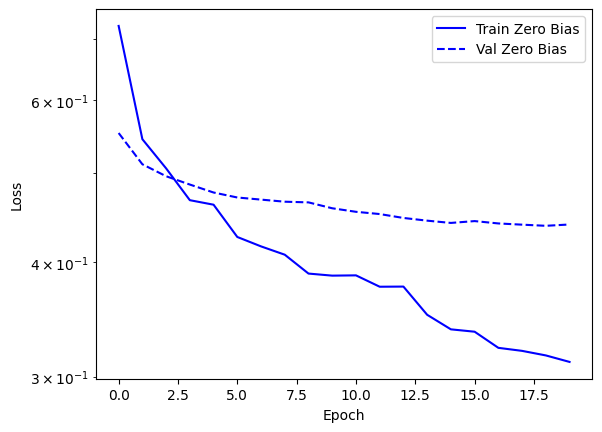

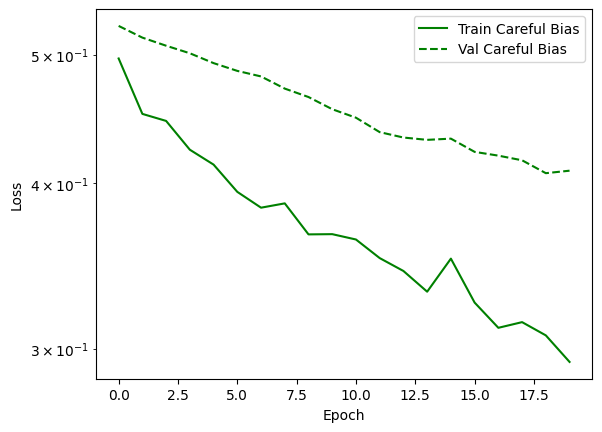

In [125]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [126]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/200
16/16 [==============================] - 2s 39ms/step - loss: 0.4846 - tp: 13.0000 - fp: 24.0000 - tn: 950.0000 - fn: 183.0000 - accuracy: 0.8231 - precision: 0.3514 - recall: 0.0663 - auc: 0.5881 - prc: 0.2379 - val_loss: 0.5237 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 139.0000 - val_fn: 37.0000 - val_accuracy: 0.7898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5666 - val_prc: 0.2653
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4719 - tp: 4.0000 - fp: 12.0000 - tn: 823.0000 - fn: 155.0000 - accuracy: 0.8320 - precision: 0.2500 - recall: 0.0252 - auc: 0.5296 - prc: 0.1843 - val_loss: 0.5140 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 139.0000 - val_fn: 37.0000 - val_accuracy: 0.7898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6113 - val_prc: 0.3308
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4343 - tp: 7.0000 - fp: 7.0000 - tn: 828.0000 - fn: 152.0000 

In [127]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()
    plt.tight_layout()
    

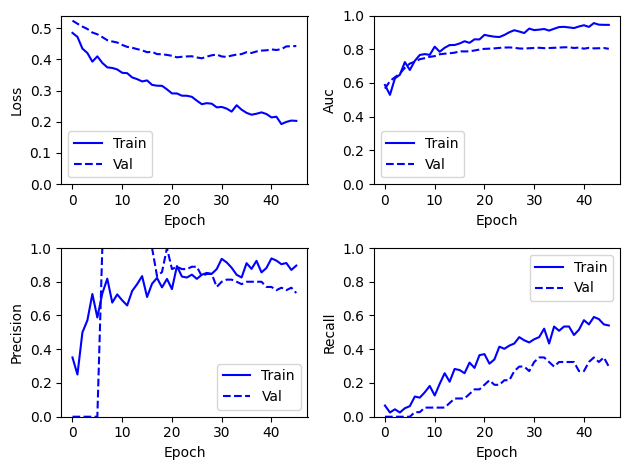

In [128]:
plot_metrics(baseline_history)
plt.show()

In [129]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


4/4 [==============================] - 0s 5ms/step


In [130]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

loss :  0.28901875019073486
tp :  8.0
fp :  6.0
tn :  174.0
fn :  19.0
accuracy :  0.8792270421981812
precision :  0.5714285969734192
recall :  0.29629629850387573
auc :  0.8457819223403931
prc :  0.5163713693618774



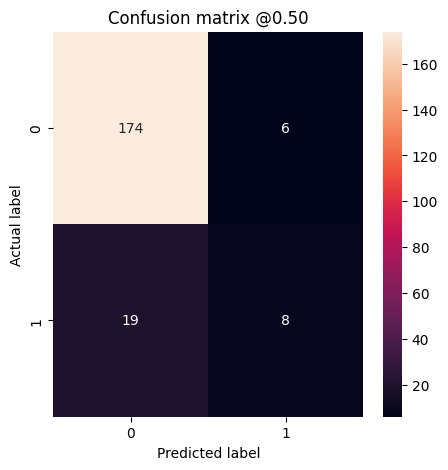

In [131]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


In [132]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([10,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

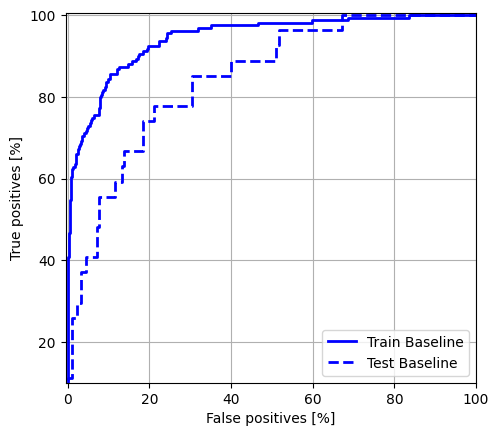

In [133]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [134]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

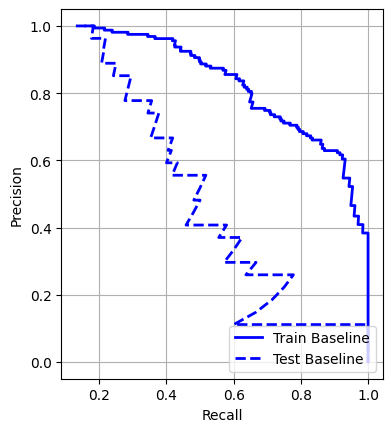

In [135]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [136]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 3.09


In [137]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/200
16/16 [==============================] - 2s 40ms/step - loss: 0.9940 - tp: 29.0000 - fp: 47.0000 - tn: 968.0000 - fn: 157.0000 - accuracy: 0.8301 - precision: 0.3816 - recall: 0.1559 - auc: 0.5859 - prc: 0.2354 - val_loss: 0.5257 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 137.0000 - val_fn: 36.0000 - val_accuracy: 0.7841 - val_precision: 0.3333 - val_recall: 0.0270 - val_auc: 0.5200 - val_prc: 0.2331
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.8592 - tp: 30.0000 - fp: 109.0000 - tn: 726.0000 - fn: 129.0000 - accuracy: 0.7606 - precision: 0.2158 - recall: 0.1887 - auc: 0.5474 - prc: 0.2179 - val_loss: 0.5349 - val_tp: 3.0000 - val_fp: 4.0000 - val_tn: 135.0000 - val_fn: 34.0000 - val_accuracy: 0.7841 - val_precision: 0.4286 - val_recall: 0.0811 - val_auc: 0.5663 - val_prc: 0.2729
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.7516 - tp: 55.0000 - fp: 145.0000 - tn: 690.0000 - fn: 104.0000 - accuracy: 0.7495 - precis

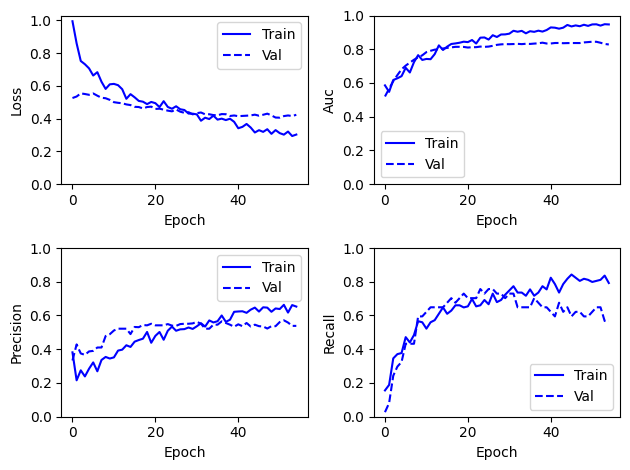

In [138]:
plot_metrics(weighted_history)
plt.show()


In [139]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)


4/4 [==============================] - 0s 5ms/step


loss :  0.43045008182525635
tp :  19.0
fp :  31.0
tn :  149.0
fn :  8.0
accuracy :  0.8115941882133484
precision :  0.3799999952316284
recall :  0.7037037014961243
auc :  0.8457819223403931
prc :  0.5277409553527832



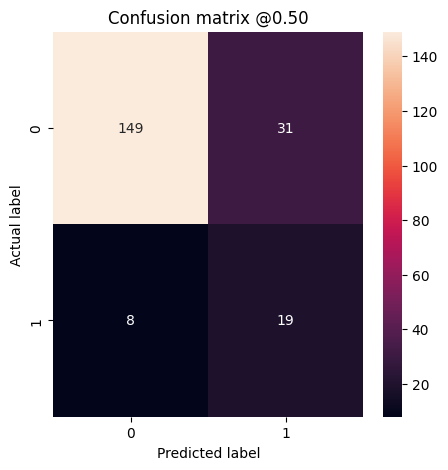

In [140]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

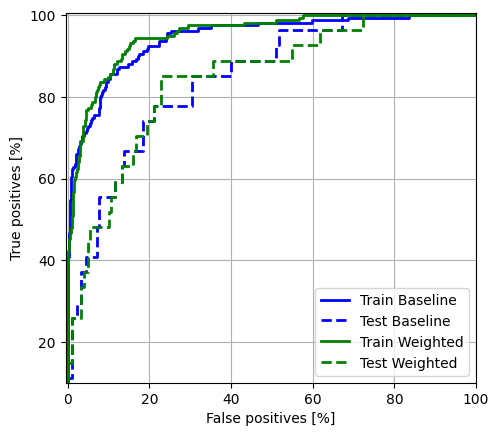

In [141]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


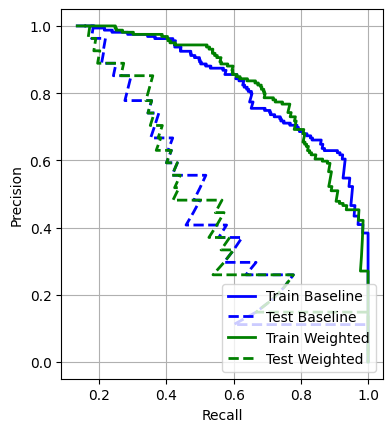

In [142]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


In [143]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [144]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(835, 55)

In [145]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1670, 55)

In [146]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [147]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [ 0.37515793  1.70118703  1.8088744   0.10577456  0.         -0.08309565
 -0.66205942  1.68351247  1.78099195  1.7466762  -0.64402167  1.4308166
  0.39125509  0.51599472  0.20991687 -0.42487947  1.18636197  0.
 -0.93494299  1.36535458 -0.58732575 -1.11973506 -0.98840974 -1.19192277
 -0.67524301 -1.16527972  3.02371578 -0.47661357 -1.58896907 -0.1993714
 -1.36851466  1.49240501 -0.1279059   1.17873792 -0.35275259 -0.67163598
 -0.23495042 -0.31745109  1.19347821 -1.19347821 -0.31745109 -0.17640956
 -0.459041   -0.26233033 -0.33815644 -0.24664234 -0.49559463  1.85404962
 -0.24664234 -0.53935989 -0.90214667  1.4380199   0.         -1.61695561
  1.61695561]

Label:  1


In [148]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.4375


In [149]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

37.0

In [150]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)


Epoch 1/200


37/37 [==============================] - 3s 20ms/step - loss: 0.7320 - tp: 647.0000 - fp: 582.0000 - tn: 782.0000 - fn: 564.0000 - accuracy: 0.5550 - precision: 0.5264 - recall: 0.5343 - auc: 0.6018 - prc: 0.5403 - val_loss: 0.6585 - val_tp: 20.0000 - val_fp: 57.0000 - val_tn: 82.0000 - val_fn: 17.0000 - val_accuracy: 0.5795 - val_precision: 0.2597 - val_recall: 0.5405 - val_auc: 0.6258 - val_prc: 0.3393
Epoch 2/200
37/37 [==============================] - 0s 5ms/step - loss: 0.6463 - tp: 689.0000 - fp: 436.0000 - tn: 760.0000 - fn: 483.0000 - accuracy: 0.6119 - precision: 0.6124 - recall: 0.5879 - auc: 0.6680 - prc: 0.6502 - val_loss: 0.6248 - val_tp: 22.0000 - val_fp: 47.0000 - val_tn: 92.0000 - val_fn: 15.0000 - val_accuracy: 0.6477 - val_precision: 0.3188 - val_recall: 0.5946 - val_auc: 0.6966 - val_prc: 0.4730
Epoch 3/200
37/37 [==============================] - 0s 6ms/step - loss: 0.5882 - tp: 744.0000 - fp: 328.0000 - tn: 853.0000 - fn: 443.0000 - accuracy: 0.6744 - precision: 0

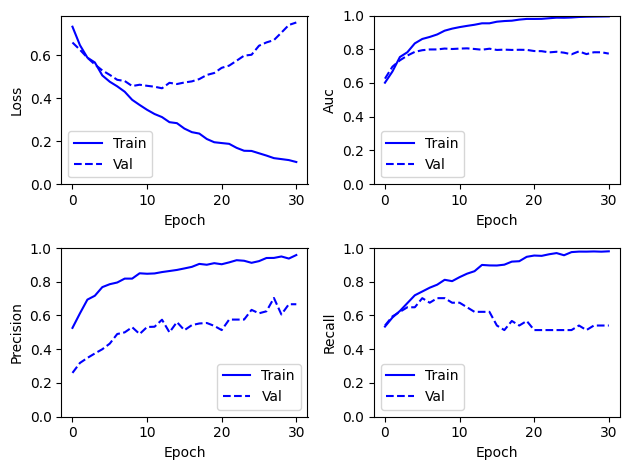

In [151]:
plot_metrics(resampled_history)
plt.show()

In [152]:
esampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))


Epoch 1/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.8026 - tp: 316.0000 - fp: 330.0000 - tn: 319.0000 - fn: 315.0000 - accuracy: 0.4961 - precision: 0.4892 - recall: 0.5008 - auc: 0.4978 - prc: 0.5024 - val_loss: 0.7215 - val_tp: 20.0000 - val_fp: 76.0000 - val_tn: 63.0000 - val_fn: 17.0000 - val_accuracy: 0.4716 - val_precision: 0.2083 - val_recall: 0.5405 - val_auc: 0.5087 - val_prc: 0.2163
Epoch 2/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.7444 - tp: 351.0000 - fp: 304.0000 - tn: 330.0000 - fn: 295.0000 - accuracy: 0.5320 - precision: 0.5359 - recall: 0.5433 - auc: 0.5516 - prc: 0.5552 - val_loss: 0.7088 - val_tp: 21.0000 - val_fp: 73.0000 - val_tn: 66.0000 - val_fn: 16.0000 - val_accuracy: 0.4943 - val_precision: 0.2234 - val_recall: 0.5676 - val_auc: 0.5396 - val_prc: 0.2439
Epoch 3/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.7178 - tp: 368.0000 - fp: 301.0000 - tn: 331.0000 - fn: 280.0000 - accuracy: 0.5461 

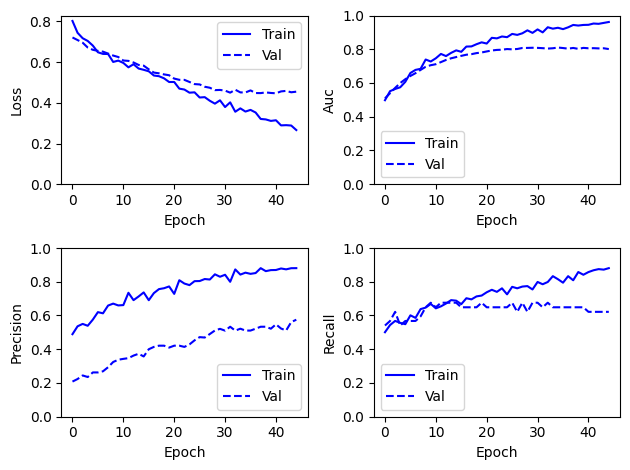

In [153]:
plot_metrics(resampled_history)
plt.show()

4/4 [==============================] - 0s 5ms/step
loss :  0.4620303511619568
tp :  19.0
fp :  31.0
tn :  149.0
fn :  8.0
accuracy :  0.8115941882133484
precision :  0.3799999952316284
recall :  0.7037037014961243
auc :  0.8308641910552979
prc :  0.45925211906433105



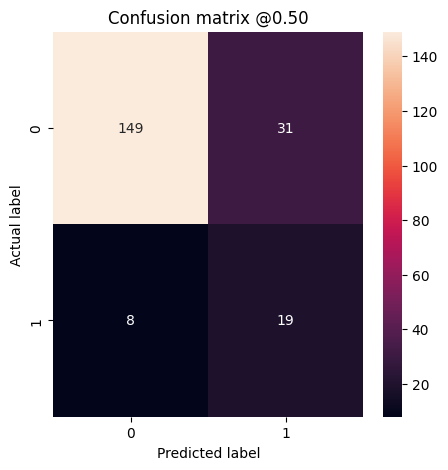

In [154]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)


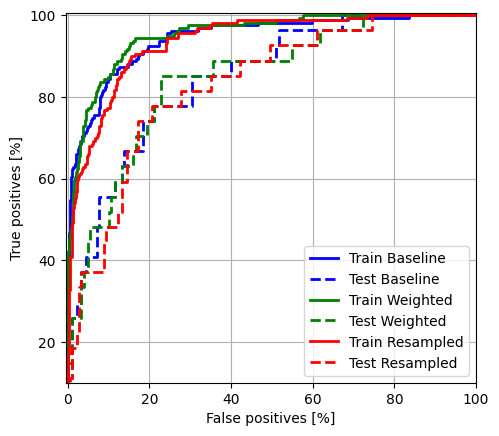

In [155]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');


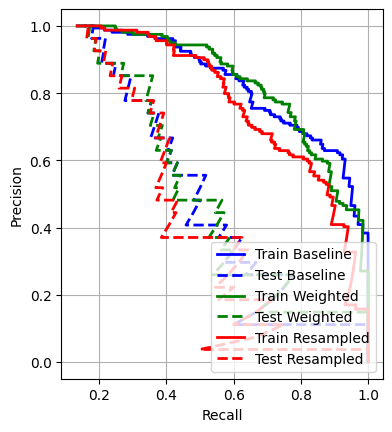

In [156]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');
